# Image Classifier Model
An image classifier (part 2 of workflow). The model predicts the classification of a catch basin image (cropped by bounding box predicted by object localizer (part 1 of workflow)).

* Input - 70x35x3 numpy array (RGB image of catch basin but cropped to only show bounding box given by object localizer)
* Output - blocked (`0`), clear (`1`), or partial (`2`)

## Imports

In [28]:
from keras.models import load_model, Sequential, Model
import tensorflow as tf
from keras import layers
from keras.preprocessing.image import img_to_array, load_img
import pathlib
import numpy as np
from PIL import Image, ImageDraw
import config
import xml.etree.ElementTree as ET
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

## Preparation of Data

Create dataframe by parsing the PASCAL VOC (XML) files.
Each file contains data about the coordinates of bounding
boxes, width, height, file name, etc. for each image in `data/`.

In [17]:
columns = ("filename", "name", "width", "height", "xmin", "ymin", "xmax", "ymax")
rows = []

for path in pathlib.Path('data').glob('*.xml'):
    tree = ET.parse(str(path))
    root = tree.getroot()
    filename = root.find("filename").text
    for obj in root.findall("object"):
        row = []
        row.append(filename)
        row.append(obj.find("name").text)
        row.append(int(root.find("size").find("width").text))
        row.append(int(root.find("size").find("height").text))
        for i in obj.find("bndbox"):
            row.append(int(i.text))
        rows.append(row)

df = pd.DataFrame(rows, columns=columns)
df.head()

,filename,name,width,height,xmin,ymin,xmax,ymax
0,01_Clear.JPG,clear,543,708,266,420,362,460
1,02_Partial.JPG,partial,621,769,202,443,307,490
2,03_Partial.JPG,partial,594,797,292,535,428,579
3,04_Clear.JPG,clear,531,779,81,462,210,550
4,05_Partial.JPG,partial,537,678,153,519,291,578


In [18]:
df = shuffle(df)

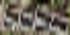

In [31]:
def crop_and_resize_img(row):
    img = load_img(pathlib.Path('data', row['filename']), target_size=object_localizer_config.image_size)
    img_arr = img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    bbox = np.asarray(row[['xmin', 'ymin', 'xmax', 'ymax']])
    bbox[0] /= row['width']
    bbox[1] /= row['height']
    bbox[2] /= row['width']
    bbox[3] /= row['height']
    bbox *= config.object_localizer_image_size[0]
    return img.crop(tuple(bbox)).resize(config.image_classifier_image_size)

crop_and_resize_img(df.iloc[1])

In [32]:
def to_categorical(name):
    if name == 'blocked':
        return np.array([1., 0., 0.])
    elif name == 'clear':
        return np.array([0., 1., 0.])
    elif name == 'partial':
        return np.array([0., 0., 1.])
    else:
        raise Exception('Invalid name')
    
to_categorical('partial')

array([0., 0., 1.])

In [44]:
X_list = []
Y_list = []
for i in range(len(df)):
    img = crop_and_resize_img(df.iloc[i])
    X_list.append(img_to_array(img))
    X_list.append(img_to_array(img.transpose(Image.FLIP_LEFT_RIGHT)))
    Y_list.append(to_categorical(df.iloc[i]['name']))
    Y_list.append(to_categorical(df.iloc[i]['name']))

X = np.asarray(X_list)
Y = np.asarray(Y_list)

## Construction of the Model
A convolutional neural network is constructed. A `Rescaling` Layer is added to normalize `RGB` values. 

In [50]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(*config.image_classifier_image_size[::-1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(33, activation='sigmoid'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 35, 70, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 35, 70, 16)        448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 17, 35, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 17, 35, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 17, 32)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 17, 64)         18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 8, 64)         

## Training

In [51]:
epochs = 10

history = model.fit(
    x=X,
    y=Y,
    validation_split=0.2,
    epochs=epochs,
    batch_size=1
)

Epoch 1/10
161/161 [==============================] - 1s 4ms/step - loss: 1.1919 - accuracy: 0.3851 - val_loss: 1.0580 - val_accuracy: 0.4390
Epoch 2/10
161/161 [==============================] - 1s 3ms/step - loss: 1.0142 - accuracy: 0.4783 - val_loss: 1.0100 - val_accuracy: 0.4878
Epoch 3/10
161/161 [==============================] - 1s 3ms/step - loss: 1.0511 - accuracy: 0.4410 - val_loss: 1.0057 - val_accuracy: 0.4634
Epoch 4/10
161/161 [==============================] - 1s 3ms/step - loss: 0.9610 - accuracy: 0.4596 - val_loss: 0.9741 - val_accuracy: 0.3415
Epoch 5/10
161/161 [==============================] - 1s 3ms/step - loss: 0.9390 - accuracy: 0.5031 - val_loss: 1.0616 - val_accuracy: 0.3902
Epoch 6/10
161/161 [==============================] - 1s 3ms/step - loss: 0.8565 - accuracy: 0.6211 - val_loss: 1.0096 - val_accuracy: 0.5366
Epoch 7/10
161/161 [==============================] - 1s 3ms/step - loss: 0.9700 - accuracy: 0.4783 - val_loss: 1.0408 - val_accuracy: 0.5122
Epoch 

## Training Analysis
See how the model did. 

Collect metrics.

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Graph the metrics

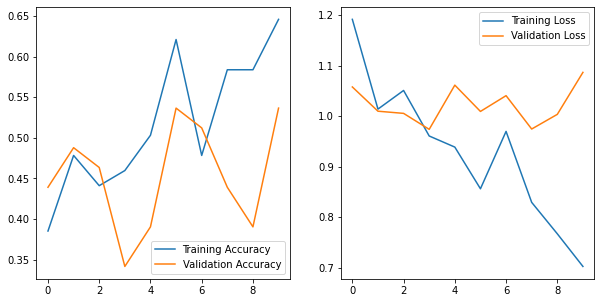

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

Print out metrics such as accuracy and loss.

In [54]:
print('accuracy:', acc[-1], 'val_accuracy:', val_acc[-1])
print('loss', loss[-1], 'val_loss:', val_loss[-1])

accuracy: 0.6459627151489258 val_accuracy: 0.5365853905677795
loss 0.7026920914649963 val_loss: 1.0869237184524536


## Saving the Model
The model is saved so that it can be loaded again for future use.

In [55]:
saved_models = pathlib.Path.cwd() / 'saved_models' / 'image_classifier_models'
if not saved_models.exists():
    saved_models.mkdir()

The following format is used for saving: `model-{num}-{acc}-{val_acc}-{loss}-{val_loss}`

In [56]:
fmt = f'{round(acc[-1], 2)}-{round(val_acc[-1], 2)}-{round(loss[-1], 2)}-{round(val_loss[-1], 2)}'

model_dirs = list(saved_models.iterdir())
if len(model_dirs) == 0: 
    model.save(saved_models / f'model-0-{fmt}')
else:
    num_strs = map(lambda x: x.name[len("model-")], saved_models.iterdir())
    num = max(list(map(lambda x: int(x), num_strs))) + 1
    model.save(saved_models / f'model-{num}-{fmt}')

INFO:tensorflow:Assets written to: C:\Users\SA\Desktop\Programming\projects\catch_basin_classifier\saved_models\image_classifier_models\model-0-0.65-0.54-0.7-1.09\assets
